# Auditing Google’s Jigsaw Toxicity Detector

## By Johnny Ma and Akshit Gandhi
## 4-12-22 - 5-9-22


### Importing packages and helper functions

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import model_selection
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_auc_score

import tqdm.notebook as tq

In [ ]:
def convert_lines(example, max_seq_length,tokenizer):
    max_seq_length -=2
    all_tokens = []
    longer = 0
    for text in tq.tqdm(example):
        tokens_a = tokenizer.tokenize(text)
        if len(tokens_a)>max_seq_length:
            tokens_a = tokens_a[:max_seq_length]
            longer += 1
        one_token = tokenizer.convert_tokens_to_ids(["[CLS]"]+tokens_a+["[SEP]"])+[0] * (max_seq_length - len(tokens_a))
        all_tokens.append(one_token)
    return np.array(all_tokens)

Read in data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('./drive/MyDrive/jigsaw-unintended-bias-in-toxicity-classification/train.csv')

In [ ]:
print(df.columns)
print(df.describe())

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')
                 id        target  severe_toxicity       obscene  \
count  1.804874e+06  1.804874e+06     1.804874e+06  1.804874e+06   
mean   3.738434e+06  1.030173e-01     4.582099e-03  1.387721e-02   
std    2.

## Input: Comment Text

In [ ]:
# pre-processing done from the Kaggle kernel. 

df['comment_text'] = df['comment_text'].astype(str) 

sequences = convert_lines(df["comment_text"].fillna("DUMMY_VALUE"),220,tokenizer)
df=df.fillna(0)
# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
y_columns=['target']

df = df.drop(['comment_text'],axis=1)
# convert target to 0,1
df['target']=(df['target']>=0.5).astype(float) # a point of contention in the competition. This method of encoding "toxic" vs. "not" was largely accepted by the participants (and us).

KeyboardInterrupt: ignored

In [ ]:
df['comment_text']

0          This is so cool. It's like, 'would you want yo...
1          Thank you!! This would make my life a lot less...
2          This is such an urgent design problem; kudos t...
3          Is this something I'll be able to install on m...
4                       haha you guys are a bunch of losers.
                                 ...                        
1804869    Maybe the tax on "things" would be collected w...
1804870    What do you call people who STILL think the di...
1804871    thank you ,,,right or wrong,,, i am following ...
1804872    Anyone who is quoted as having the following e...
1804873    Students defined as EBD are legally just as di...
Name: comment_text, Length: 1804874, dtype: object

In [ ]:
# number of missing
print(df['comment_text'].isna().sum())

0


In [ ]:
# word count of each comment
from sklearn.feature_extraction.text import CountVectorizer
corpus = df['comment_text']
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['00', '000', '0000', ..., '𝟯𝟬𝟲', '𝟯𝟱𝟲', '𝟳𝟱𝟬'], dtype=object)

In [ ]:
from scipy.sparse import *
m = csr_matrix.sum(X, axis = 1)

Text(0.5, 1.0, 'Histogram of # of words in each comment')

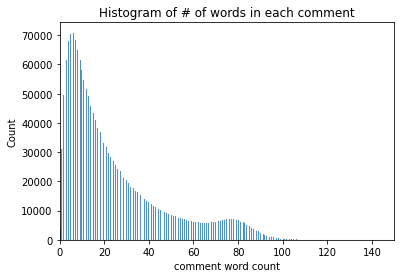

In [ ]:
sns.histplot(m.A1, label = 'word count')
plt.xlim([0,150])
plt.xlabel('comment word count')
plt.title('Histogram of # of words in each comment')

# Output: Target Toxicity Label and Extra Subgroups

The target variable is "target" that measures toxicity. We will look into the other labels - severe_toxicity
- obscene
- threat
- insult
- identity_attack
- sexual_explicit

as a supplement.

In [ ]:
print(df['target'])

print(df['target'].describe())

# number of missing
print(df['target'].isna().sum())

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.893617
             ...   
1804869    0.000000
1804870    0.000000
1804871    0.000000
1804872    0.621212
1804873    0.000000
Name: target, Length: 1804874, dtype: float64
count    1.804874e+06
mean     1.030173e-01
std      1.970757e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e-01
max      1.000000e+00
Name: target, dtype: float64
0


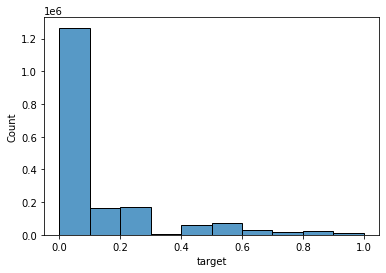

In [ ]:
sns.histplot(df['target'], bins = 10)

The vast majority are not toxic ! There appears to be a bi-modal distribution here as well, likely related to the "intent" of the author to be toxic or not.

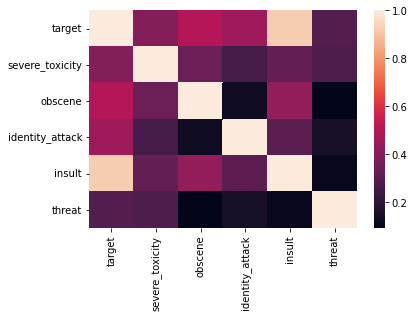

In [ ]:
toxicity_columns = ['target', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat']

sns.heatmap(df[toxicity_columns].corr());

We see that the target variable expresses a good mixture of the other subcategories, and is likely justified as an aggregate measure of toxicity. 

## Output: Which Identity is being mentioned?

We analyze the same identity columns that our Kaggle model of choice analyzes, though there are others.

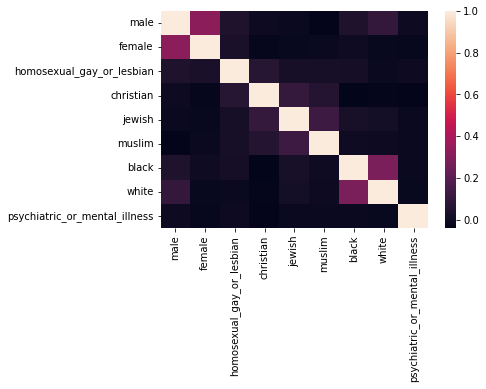

In [ ]:
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

sns.heatmap(df[identity_columns].corr());

It appears most comments are targetted towards a specific group, with some relationship between males and females and black and white, which are large and frequently talked about subgroups in the media and online.

## Example Analysis: Are longer comments more toxic?

In [ ]:
df['comment_length'] = m.A1

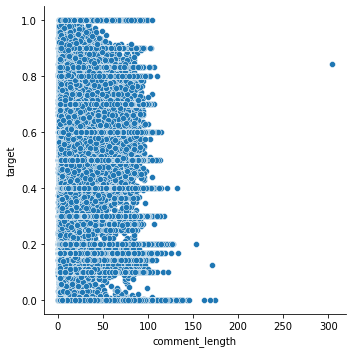

In [ ]:
sns.relplot(x="comment_length", y="target", data=df);

## Model: Kaggle Model from https://www.kaggle.com/code/yuval6967/toxic-bert-plain-vanila/notebook

In [ ]:
!pip install transformers -q 

     |████████████████████████████████| 4.0 MB 6.8 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 6.6 MB 35.7 MB/s 
     |████████████████████████████████| 880 kB 55.5 MB/s 
     |████████████████████████████████| 596 kB 60.2 MB/s 


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

In [ ]:
model_location = './drive/MyDrive/jigsaw-unintended-bias-in-toxicity-classification/'
device = torch.device('cuda')

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(model_location, num_labels = 1)
model.to(device)
for param in model.parameters():
    param.requires_grad=False
model.eval()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Running Experiments over Test Data

In [ ]:
test_df = pd.read_csv("./drive/MyDrive/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv")
test_df['comment_text'] = test_df['comment_text'].astype(str) 
X_test = convert_lines(test_df["comment_text"].fillna("DUMMY_VALUE"), 220, tokenizer)

  0%|          | 0/97320 [00:00<?, ?it/s]

In [ ]:
# using the model to make toxicity predictions over the test data

test_preds = np.zeros((len(X_test)))
test = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.long))
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)
tk0 = tq.tqdm(test_loader)

for i, (x_batch,) in enumerate(tk0):
    pred = model(x_batch.to(device), attention_mask=(x_batch > 0).to(device), labels=None)
    test_preds[i * 32:(i + 1) * 32] = pred['logits'][:, 0].detach().cpu().squeeze().numpy()

test_pred = torch.sigmoid(torch.tensor(test_preds)).numpy().ravel()

  0%|          | 0/3042 [00:00<?, ?it/s]

In [ ]:
test_df['bert'] = test_pred >= 0.5
test_df.to_csv('test_df_preds.csv')

## Fairness Metrics

In [ ]:
# importing the metrics provided by the base Kernel of the competition, re-written for our configuration and project.

def calculate_overall_auc(df, model_name):
    true_labels = df['toxicity']>0.5 # this threshold was a point of contention in the original submission, but I'm leaving it at 0.5 to reproduce the Kaggle results.
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

SUBGROUP_AUC = 'subgroup_auc' # performance on subgroups
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative. i.e., non-toxic that mention identity, and toxic examples that do not.
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive. i.e., toxic examples that mention identity and non-toxic that do not.

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]>0.5]
    return compute_auc((subgroup_examples[label]>0.5), subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[(df[subgroup]>0.5) & (df[label]<=0.5)]
    non_subgroup_positive_examples = df[(df[subgroup]<=0.5) & (df[label]>0.5)]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label]>0.5, examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[(df[subgroup]>0.5) & (df[label]>0.5)]
    non_subgroup_negative_examples = df[(df[subgroup]<=0.5) & (df[label]<=0.5)]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label]>0.5, examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]>0.5])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

In [ ]:
test_df.head()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,...,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,bert
0,7000000,Jeff Sessions is another one of Trump's Orwell...,2017-01-26 07:37:38.422417+00,13,NaN,164149,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,7000001,I actually inspected the infrastructure on Gra...,2016-12-03 20:38:21.204649+00,54,655260.0,154341,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,7000002,No it won't . That's just wishful thinking on ...,2017-05-05 18:07:58.560078+00,21,5219683.0,332005,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,7000003,Instead of wringing our hands and nibbling the...,2017-02-09 14:46:30.189044+00,13,NaN,167110,approved,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,7000004,how many of you commenters have garbage piled ...,2016-10-15 01:18:40.521923+00,21,NaN,148484,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(test_df, identity_columns, 'bert', 'toxicity')
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
6,black,699,0.750621,0.797801,0.816309
2,homosexual_gay_or_lesbian,491,0.778528,0.826545,0.811650
5,muslim,914,0.792441,0.830853,0.822795
7,white,1204,0.793438,0.810705,0.844669
3,christian,1828,0.819517,0.861987,0.816848
4,jewish,405,0.827560,0.849129,0.835992
1,female,2392,0.845767,0.853393,0.850789
8,psychiatric_or_mental_illness,214,0.855360,0.845292,0.866903
0,male,2053,0.860390,0.845329,0.871024


## SHAP For BERT

In [ ]:
!pip install shap -q

     |████████████████████████████████| 564 kB 7.4 MB/s 


## SHAP on a missed toxic comment for LGBTQ+ groups

In [ ]:
import shap
import scipy as sp

In [ ]:
# custom SHAP function. you won't believe how long this took to get right.
def model_prediction(x):
  tv = torch.tensor([tokenizer.encode(v, padding='max_length', 
                                        max_length=220, truncation=True) for v in x]).cuda()
  attention_mask = (tv!=0).type(torch.int64).cuda()
  outputs = model(tv, attention_mask=attention_mask)
  out = outputs['logits'][:, 0].detach().cpu().squeeze().numpy()
  val = torch.sigmoid(torch.tensor(out)).numpy().ravel()

  return val

In [ ]:
success = test_df.loc[(test_df['target'] == True) & (test_df['bert']==True)]
success.head()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,...,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,bert,target
4,7000004,how many of you commenters have garbage piled ...,2016-10-15 01:18:40.521923+00,21,NaN,148484,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
24,7000024,Corrupt hypocrites throughout he government. O...,2017-09-23 14:30:58.034782+00,102,NaN,381079,approved,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,True,True
55,7000055,Fool.,2017-02-04 01:30:01.812928+00,21,896498.0,163887,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
90,7000090,LIAR LIAR PANTS ON FIRE......how dumb does he ...,2017-01-25 13:00:00.790787+00,54,NaN,163903,rejected,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,True,True
182,7000182,Did you even read the link provided? I sure h...,2017-06-22 21:39:57.008056+00,102,5461358.0,347375,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True


In [ ]:
explainer = shap.Explainer(model_prediction, tokenizer)
shap_values = explainer([success['comment_text'].iloc[0]]) # first example of succesfull classification
output = shap.plots.text(shap_values)
output

In [ ]:
test_df['target'] = test_df['toxicity'] >= 0.5
fails = test_df.loc[test_df['target'] != test_df['bert']] # where predictions fail
LGBTQ_fails = fails.loc[fails['homosexual_gay_or_lesbian']>=0.5] # is in this subgroup
print(len(LGBTQ_fails))
LGBTQ_fails[['comment_text', 'homosexual_gay_or_lesbian', 'target', 'bert']].head()

96


,comment_text,homosexual_gay_or_lesbian,target,bert
57,Motley: this is an interesting topic. Certai...,0.600000,True,False
395,Castro put gay people in concentration camps. ...,0.900000,False,True
2100,I am surprised you think political thought is ...,0.833333,True,False
2627,Having a gay husband?,1.000000,False,True
4013,But what happens if a disgruntled Canadian bla...,0.900000,True,False


##

In [ ]:
fail_test = LGBTQ_fails.loc[(LGBTQ_fails['target'] == True) & (LGBTQ_fails['bert'] == False)]
fail_test['comment_text'].head()

57      Motley:  this is an interesting topic.  Certai...
2100    I am surprised you think political thought is ...
4013    But what happens if a disgruntled Canadian bla...
4015    Maybe...just MAYBE...it's personal choice? Eve...
8655    I wonder what would have happened had the Dona...
Name: comment_text, dtype: object

In [ ]:
explainer = shap.Explainer(model_prediction, tokenizer)
shap_values = explainer([fail_test['comment_text'].loc[4015]]) # specific instance selected

In [ ]:
output = shap.plots.text(shap_values)
output

In [ ]:
fail_test = LGBTQ_fails.loc[(LGBTQ_fails['target'] == False) & (LGBTQ_fails['bert'] == True)]
fail_test['comment_text'].head()

395      Castro put gay people in concentration camps. ...
2627                                 Having a gay husband?
10348    I'm in favor of married priests, women priests...
11573    In fact, what happens--and I have seen it more...
11850    Mean comment by a mean person.  Have you ever ...
Name: comment_text, dtype: object

In [ ]:
explainer = shap.Explainer(model_prediction, tokenizer)
shap_values = explainer([fail_test['comment_text'].iloc[2]]) # specific instance selected

In [ ]:
output = shap.plots.text(shap_values)
output